# Trading Agent Development
Inspiration:
- https://www.backtrader.com/blog/posts/2015-08-16-backtesting-with-almost-no-programming/backtesting-with-almost-no-programming/ (Backtrader Platform würde einige Funktionen bereitstellen)
- https://github.com/tmorgan4/btgym_Kismuz?tab=readme-ov-file
- 

In [15]:
import src.utils.file_management as filemgmt
import src.pipeline.preprocessing as preprocessing
import src.pipeline.predictors as predictors
from src.pipeline.predictors import LSTMPredictor

from itertools import product
import gym
from gym import spaces
from typing import Union, Literal
import numpy as np
import pandas as pd
import random
import enum

from pathlib import Path

from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

## Initialisation

In [3]:
ROOT = Path().resolve().parent

DATA = ROOT / "data"
INTERPOLATED_PRICES = DATA / "interpolated_prices"

SAVED_MODELS = DATA / "saved_models"

In [4]:
SAVED_B1_PREDICTOR = SAVED_MODELS / "predictor_b1" / "2025-05-22 10_03_41 LSTM Model RW68 FH14 Layers3 Size256 TrainL0.10641186928842217 ValL1.9110333621501923 TrainHR0.4860040545463562 ValHR0.5328466892242432.pt"
SAVED_B3_PREDICTOR = SAVED_MODELS / "predictor_b3" / "2025-05-22 11_47_10 LSTM Model RW40 FH5 Layers3 Size128 TrainL0.36055382899940014 ValL1.9578219056129456 TrainHR0.547325074672699 ValHR0.529629647731781.pt" 
SAVED_C1_PREDICTOR = SAVED_MODELS / "predictor_c1" / "2025-05-22 11_27_18 LSTM Model RW24 FH3 Layers4 Size128 TrainL0.29682125337421894 ValL0.4320639967918396 TrainHR0.5574468374252319 ValHR0.5660377144813538.pt"

In [5]:
ENV_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '15min')
B1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '60min')
B3_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '1d')
C1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '7d')

## Predictors

In [6]:
b1_predictor = LSTMPredictor(model_load_file_path=SAVED_B1_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=B1_PRICE_FILE,
                             daily_prediction_hour=20,  # these are necessary data properties which still need to be set
                             predict_before_daily_prediction_hour=True,
                             rolling_window_size=68,
                             forecast_horizon=14,
                             sampling_rate_minutes=60)
b1_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.
Created rolling window view based on rolling_window_size of 68 and forecast_horizon of 14 with a time unit of 60 minutes.
Target values start at only observation between 20:00 and 21:00 daily.
Resulting dataset consists of 2739 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 2191 training and 548 validation observations.


------------------- LSTMPredictor Instance -------------------

Data Attributes:
- sampling rate in minutes: 60
- daily prediction hour: 20:00
- predicting at last observation before prediction hour: True
- rolling window size: 68
- forecast horizon: 14
- validation split: 0.2
- amount of training observations: 2191
- amount of validation observations: 548

Model Attributes:
- hidden LSTM layers: 256
- number of LSTM layers: 3
- pre LSTM fully connected layer: False

Model wasn't trained yet (or was imported).

In [7]:
b3_predictor = LSTMPredictor(model_load_file_path=SAVED_B3_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=B3_PRICE_FILE,
                             daily_prediction_hour=20,  # these are necessary data properties which still need to be set
                             rolling_window_size=40,  # 2 months a 4 weeks a 5 days hindsight
                             forecast_horizon=5,  # 1 week a 5 days ahead
                             sampling_rate_minutes=60*14,  # one day from 8 to 22
                             )
b3_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.
Created rolling window view based on rolling_window_size of 40 and forecast_horizon of 5 with a time unit of 840 minutes.
Target values start at only observation between 20:00 and 21:00 daily.
Resulting dataset consists of 2700 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 2160 training and 540 validation observations.


------------------- LSTMPredictor Instance -------------------

Data Attributes:
- sampling rate in minutes: 840
- daily prediction hour: 20:00
- predicting at last observation before prediction hour: False
- rolling window size: 40
- forecast horizon: 5
- validation split: 0.2
- amount of training observations: 2160
- amount of validation observations: 540

Model Attributes:
- hidden LSTM layers: 128
- number of LSTM layers: 3
- pre LSTM fully connected layer: False

Model wasn't trained yet (or was imported).

In [8]:
c1_predictor = LSTMPredictor(model_load_file_path=SAVED_C1_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=C1_PRICE_FILE,
                             daily_prediction_hour=20,  # these are necessary data properties which still need to be set
                             rolling_window_size=40,  # 2 months hindsight
                             forecast_horizon=5,  # 1 week ahead
                             sampling_rate_minutes=5*14*60,  # 1 week a 5 days from 8 to 22
                             )
c1_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.
Created rolling window view based on rolling_window_size of 40 and forecast_horizon of 5 with a time unit of 4200 minutes.
Target values start at only observation between 20:00 and 21:00 daily.
Resulting dataset consists of 505 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 404 training and 101 validation observations.


------------------- LSTMPredictor Instance -------------------

Data Attributes:
- sampling rate in minutes: 4200
- daily prediction hour: 20:00
- predicting at last observation before prediction hour: False
- rolling window size: 40
- forecast horizon: 5
- validation split: 0.2
- amount of training observations: 404
- amount of validation observations: 101

Model Attributes:
- hidden LSTM layers: 128
- number of LSTM layers: 4
- pre LSTM fully connected layer: False

Model wasn't trained yet (or was imported).

### Example Prediction

## Environment
https://github.com/tmorgan4/btgym_Kismuz/blob/master/btgym/strategy/base.py

In [9]:
class TradingActionsAll(enum.Enum):
    """ Actions for trading. Buy or sell all. No amount possible. """
    Hold = 0
    Buy = 1
    Sell = 2

In [10]:
# Todo: observation space with predictor data

In [21]:
class RLTradingEnv(gym.Env):
    """
    A trading environment for OpenAI gym.
    
    Environment is called (stepped) every day in the provided price_data at all daily_prediction_times present in the predictor_instances.
    """
    metadata = {'render.modes': ['human']}
    def __init__(self,
                 price_csv_path: Union[str, Path],
                 price_sampling_rate_minutes: int = 1,
                 price_column='close',
                 date_column='date',
                 predictor_instances: [LSTMPredictor] = None,  # to be imported for data preparation
                 # Todo: possible_products (i.e., which certificates)  # used to define action space
                 possible_trade_quantities: Literal['all', 'fixed', 'arbitrary'] = 'all',  # used to define action space
                 starting_cash=100000,
                 commission_rate=0,
                 verbose=True
                 ):
        """
        TO BE DESCRIBED!
        """
        super(RLTradingEnv, self).__init__()  # initialise base class
        self.price_series = preprocessing.read_price_csv(csv_path=price_csv_path, date_column=date_column, price_column=price_column)
        
        self.price_sampling_rate_minutes = price_sampling_rate_minutes
        self.price_column = price_column
        self.date_column = date_column

        self.starting_cash = starting_cash
        self.commission_rate = commission_rate
        self.verbose = verbose

        # current episode (sequence of steps)
        self.current_episode = 0
        
        self.predictor_instances = predictor_instances
        self._daily_prediction_hours = None
        '''
        if predictor_instances is not None:
            # necessary parameters for data preparation to construct observation space
            if len(predictor_instances) == 1: predictor_instances = list(predictor_instances)
            obs_param_tuples = [(predictor.rolling_window_size, predictor.sampling_rate_minutes, predictor.daily_prediction_hour, predictor.predict_before_daily_prediction_hour) for predictor in predictor_instances]
        else:
            raise AttributeError("Predictor instances need to be provided. Manual observation space definition not implemented yet.")
        
        total_rolling_window_size = np.sum([params[0] for params in  obs_param_tuples])  # for observation space construction
        if self.verbose: print(f"Constructing observation space for {len(obs_param_tuples)} predictors.\nProperties:\n(rolling_window_size, sampling_rate_minutes, daily_prediction_hour, predict_before_daily_prediction_hour)\n{obs_param_tuples}")
        '''
        # step dates (property to be calculated upon read-out)
        self._step_dates_list = None
        
        # current step (status and actions)
        self.current_step = 0
        

        # set of possible actions as discrete values:
        if possible_trade_quantities == 'all':
            self.action_space = spaces.Discrete(len(TradingActionsAll))
        elif possible_trade_quantities == 'fixed':
            raise NotImplementedError("Fixed trading quantities are yet to be implemented.")
        elif possible_trade_quantities == 'arbitrary':
            raise NotImplementedError("Arbitrary trading quantities are yet to be implemented.")
        else:
            raise ValueError("possible_trade_quantities can only be 'all', 'fixed', 'arbitrary'")
        
        # set of floats representing available information for agent:
        self.observation_space = spaces.Box(low=-np.inf,
                                            high=np.inf,
                                            shape=(len(predictor_instances)+3,),
                                            dtype=np.float16)
        # contains floats of each predictor's output and three more for (cash, price and action)

        # possible range of rewards for actions:
        self.reward_range = (-np.inf, np.inf)

        # initial conditions:
        self.cash = self.starting_cash
        self.shares = 0

    def step(self, action):
        """
        Execute an action, return the reward and move to the next status.
        Takes action.
        Returns observation (box), reward (float), done (bool, indicating whether episode is finished) and info (dict).
        """
        # infer current balance:
        balance = self.current_balance

        # increase step
        self.current_step += 1
        if self.current_step == self.total_steps:  # if episode is finished
            self.current_episode = self.next_episode()
            self.current_step = 0  # reset current step

        # take action:
        self.take_action(action)

        # compute status and calculate reward:
        obs = self.next_observation(action)
        reward = self.current_balance - balance  # equals change of balance
        done = (self.current_step == self.total_steps - 1)  # see if episode is finished

        # construct info dictionary:
        info = { 'Step'  : self.current_step,
                 'Reward' : round(reward, 2),
                 'Action' : TradingActionsAll(action).name,
                 'Shares' : self.shares,
                 'Close'  : round(self.current_price, 2),
                 'Cash'   : round(self.cash, 2),
                 'Total'  : round(self.current_balance, 2) }

        # if done: self.reset()  # happens automatically!

        return obs, reward, done, info

    def take_action(self, action):
        """ Takes action and updates current balance. Hold has no implication. Considers commission_rate """
        if action == TradingActionsAll.Buy.value:  # buy all:
            if self.shares == 0:  # only if no shares held:
                price = self.current_price * (1 + self.commission_rate)
                self.shares = int(self.cash / price)
                self.cash -= self.shares * price
                if self.verbose:
                    print(f"[STEP {self.current_step}] Bought at {self.current_price}")
                    print(f"    Cash: {self.cash}, Shares: {self.shares}")
        elif action == TradingActionsAll.Sell.value:  # sell all:
            if self.shares > 0:  # only if there are shares to sell:
                price = self.current_price * (1 - self.commission_rate)
                self.cash += self.shares * price
                self.shares = 0
                if self.verbose:
                    print(f"[STEP {self.current_step}] Sold at {self.current_price}")
                    print(f"    Cash: {self.cash}, Shares: {self.shares}")
    
    # todo: call predictors and construct observation space
    def next_observation(self, action):
        """ Construct and return new observable status. Reads current indicators (for sample_days), cash, balance and action. """
        observation = np.array([], dtype=np.int64)
        # todo: iterate over predictors
        for i in range(self.sample_days, 0, -1):
            observation = np.append(observation, list(self.current_indicators.iloc[self.current_step - i + 1, :]))
            
        # todo: return all information
        return np.append(observation, [self.cash, self.shares * self.current_price, action])

    def next_episode(self):
        """ Select stock to be trained at beginning of episode. """
        return (self.current_episode + 1) % self.total_episodes

    def reset(self):
        """ Initialises environment when starting new episode. Returns next status. """
        if self.verbose:  # info statement
            print(f"Starting episode {self.current_episode + 1}", (f"/{self.total_episodes}"))
        self.cash = self.starting_cash
        self.shares = 0
        return self.next_observation(TradingActionsAll.Hold.value)

    def get_current_predictor_input(self, rolling_window_size: int, sampling_rate_minutes: int, predict_before_daily_prediction_hour: bool = False) -> np.ndarray:
        """ Sample price series and create rolling window view for predictor input. """
        # calculate start int index for rolling window (if not predicting before daily prediction hour add 1 index:
        start_index = int(self.current_step_int_index - rolling_window_size * sampling_rate_minutes / self.price_sampling_rate_minutes)
        
        # sanity check:
        if start_index < 0: raise ValueError("Rolling window size too large for current step.")
        
        # slice according to start and end index (adjusted by +1 if prediction should be after prediction hour) and sampling rate:
        sampled_prices = self.price_series.iloc[start_index+(not predict_before_daily_prediction_hour):self.current_step_int_index+(not predict_before_daily_prediction_hour):int(sampling_rate_minutes / self.price_sampling_rate_minutes)]
        
        return sampled_prices

    ################ properties ################
    @property
    def total_episodes(self):
        """ Total episodes equals amount of provided stock data frames. """
        # todo: method currently unnecessary
        return 1

    @property
    def total_steps(self):
        """ One step per day and distinct prediction hour. """
        return len(self.step_dates_list)
    
    @property
    def no_of_days(self):
        """ Number of days in the provided price series. """
        return int(len(self.step_dates_list) / len(self.daily_prediction_hours))  # step dates list has multiple entries for multiple prediction hours 
    
    @property
    def daily_prediction_hours(self):
        if self._daily_prediction_hours is None:
            self._daily_prediction_hours = {predictor.daily_prediction_hour for predictor in self.predictor_instances}  # at every distinct prediction hour (sets correct for duplicates)
        return self._daily_prediction_hours
            
    @property
    def step_dates_list(self):
        """ Dates for each day in the price series at each distinct prediction hour. """
        if self._step_dates_list is None:
            grouped = self.price_series.groupby(by=[self.price_series.index.year, self.price_series.index.month, self.price_series.index.day]).min()
            # multiple entries for each distinct prediction hour:
            self._step_dates_list = [f"{year}-{month}-{day}" for (year, month, day), pred_hour in product(grouped.index, self.daily_prediction_hours)]
        return self._step_dates_list
    
    @property
    def current_price(self):
        """ Close price at the current step's time. """
        return self.price_series[self.current_step_date_with_time].item()
        
    @property
    def current_prediction_hour(self):
        return list(self.daily_prediction_hours)[(self.current_step % len(self.daily_prediction_hours))]
    
    @property
    def current_step_date(self):
        return self.step_dates_list[self.current_step]
    
    @property
    def current_step_date_with_time(self) -> pd.Timestamp:
        """ Return timestamp of current step's datetime. """
        try:
            return self.price_series[f"{self.current_step_date} {f'0{self.current_prediction_hour}' if self.current_prediction_hour < 10 else self.current_prediction_hour}"].iloc[0:1].index.item()
        except KeyError:  # recursion with next step if IndexError (because then no data present for that prediction hour or day)
            self.current_step += 1
            return self.current_step_date_with_time
        
    @property
    def current_step_int_index(self) -> int:
        return np.argwhere(self.price_series[:self.current_step_date_with_time])[-1].item()  # last index = index of current_step_date_with_time

    @property
    def current_balance(self):
        """ Current balance equals cash plus current shares times current price. """
        return self.cash + (self.shares * self.current_price)

In [22]:
self = RLTradingEnv(ENV_PRICE_FILE,
                    price_sampling_rate_minutes=15,
                    predictor_instances=(b1_predictor, b3_predictor, c1_predictor))

In [23]:
self.current_step_int_index

16

In [ ]:
self.step = 510

Prices are expected to go UP!


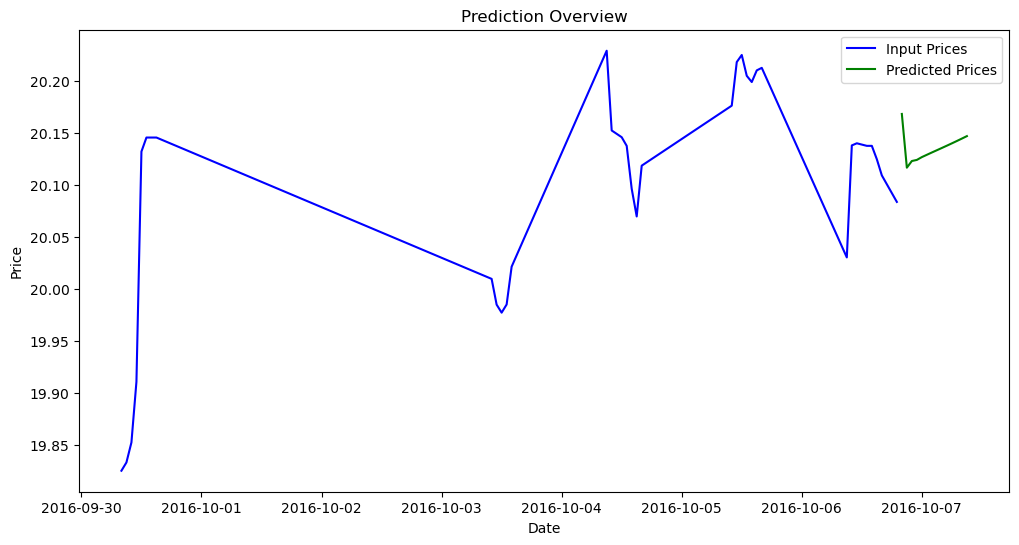

In [41]:
predictor = self.predictor_instances[0]
input = self.get_current_predictor_input(predictor.rolling_window_size, sampling_rate_minutes=predictor.sampling_rate_minutes, predict_before_daily_prediction_hour=predictor.predict_before_daily_prediction_hour)

prices, dates, tendency = predictor.predict(input, return_tendency=True)

In [42]:
tendency

'up'